# Random Forests

<div class="alert alert-block alert-info">
<ul><strong>
<li>MIGUEL DOMINGUEZ</li>
<li>CSC 59929</li>
<li>Machine Learning</li>
<li>Prof. Erik K. Grimmelmann </li>
<li>Date: 10/31/17 </li>
<li>Homework Week 9 </li>
</strong>
</ul>
</div>

<div class="alert alert-block alert-warning">
<h2>Keywords</h2>
<ul>
<li><b>weak learner:</b> a classifier whose results are only slighly correlated with the true classification</li>
<li><b>strong learner:</b> robust model, can be built from weak learners to have a better generalization error and be less likely to be influended by overfitting</li>
<li><b>random forest:</b> an ensemble or group of decision trees, has good scalability, good performance classification and easy to use </li>
<li><b>bootstrap:</b> randomly choosing fixed sized samples from the training set with replacement</li>
<li><b>majority vote:</b> majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes </li>
<li><b>out-of-bag:</b> baging means that we take random samples with repetition allowed, this means that some samples might have duplicates or they can have missing data from the given training data. A data point is said to be out of the bag for the bootstrap samples that do not contain it. The idea is to use the samples not containing (missingX, missingY) so that the models will then predict missing Y when we give them missing X. We are predicting with extra test data while still having testing data not included in the training.</li>
</ul>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator 
from matplotlib.colors import ListedColormap
from IPython.display import Image
%matplotlib inline
import graphviz 
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from astropy.table import Table, Column

## Discussion and Results:

<div class="alert alert-block alert-success">
Here, we learn about how Random Forests work and how useful they are in classification. We use the Iris Dataset to demonstrate how Random Forests can be implemented. To start, we need to learn about about the algorithm behind Random Forests. The first step is to use bootstrapping, which means to randomly pick samples from the training data with replacement. Each bootstrap sample will be used for one Decision Tree. Each individual tree can also pick how many features to use for the node divisions. Consequently, we will have many trees which classify data according to what each tree learned. To decide how the entire forest should classify a data value we use majority voting, in other words, use the most frequent class selection that the trees give us. 
<br><br>
For our implementation, we use Decision Trees of depths 1 , 2 and 3. As well, we change the forest size from 10 trees up to 100 trees. In theory, more trees will increase the accuracy of the entire forest but more means higher cost as well. So for each depth we use all forest sizes and create decision trees that take the training data but this data is bootstrapped. We use random_state = 1 as the parameters for the classifier model in order to bootstrap, as well we set oob_score = True in order to get the out-of-bag accuracy for each tree. Our results indicate that for forests with depth 1 (reminds me of small green pea plants grouped together), the out-of-bag scored was low, around 74% for the highest, lowest was 63%. Next we move to forests with depth 2, here we found better results, highest was 95% and lowest was 89%. Finally for forests with depth 3, the out-of-bag score stays between 94% to 95%. A surprising result was that some forests with more trees produced a worse accuracy that forests with less tree. This alarms our attention to further investigate more about if such bigger forests tended to overfit the models. Perhaps since the Iris data set is rather small this occured. But in general, trees with higher depth provide more accurate classifications. 
<br><br>
All results can be seen in the table and also a graph for the out-of-bag scores is provided. 
</div>

In [3]:
#Obtain Iris Dataset and save it to a Pandas Frame
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header = None)
#Rename columns
new_columns = ['Sepal Length [0]', 'Sepal Width [1]', 'Petal Length [2]', 'Petal Width [3]','Class']
iris.columns = new_columns
iris.head()

,Sepal Length [0],Sepal Width [1],Petal Length [2],Petal Width [3],Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#We use all 3 flower clases (SVV means Setosa & Versicolor & Virginica)
SVV = iris.iloc[:,:].values

#Standardize the features
for i in range(0,4):
    SVV[:,i] = (SVV[:,i] - SVV[:,i].mean()) / SVV[:,i].std()   

#Samples    
X = SVV[:,0:4]    

#Get class vector
y = SVV[:,4]
for i in range(0,len(y)):
    if y[i] == 'Iris-setosa':
        y[i] = 0
    elif y[i] == 'Iris-versicolor':
         y[i] = 1
    else:
         y[i] = 2
#Convert Y to list
y = y.tolist()

In [5]:
# Split data into 70% training and 30% test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.30, random_state=0)

## Algorithm for Random Forests

<ol>
  <li>Draw a bootstrap sample of size n, it means to pick n random samples from the training dataset. Replacement is allowed</li>
  <li>Grow a decision tree for the bootstrap sample. At each node:
  <ul>
  <li>Randomly select d features, no replacement. </li>
  <li>Split node using best split feature, according to the function, like the information gain. </li>
  </ul>
  </li>
  <li>Repeat 1 and 2 k times.</li>
  <li>Combine Predictions by each tree to assign the class label, we do this by majority vote.</li>
</ol>

In [6]:
#Specify tree depths and forest sizes
depths = [1,2,3]
forest_size = [10,15,20,25,50,100]
scores = np.zeros((len(depths),len(forest_size)))
#For table labels
depth_col = [] 
forest_size_col = []


for i,depth in enumerate(depths):
    for j,size in enumerate(forest_size):
        forest = RandomForestClassifier(criterion='entropy', n_estimators=size, oob_score = True, 
                                        max_depth = depth,  random_state=1, n_jobs=2)
        #Training and accuracy for each forest
        forest.fit(X_train, y_train)
        scores[i,j] = forest.oob_score_
        #print(forest.oob_score_)
        
        #Collect labels for table
        depth_col.append(depth)
        forest_size_col.append(size)

In [7]:
#Gather data for table
outofbag = np.concatenate((scores[0,:],scores[1,:]))
outofbag = np.concatenate((outofbag,scores[2,:]))

#Table of Results
table = Table([depth_col, forest_size_col, outofbag], 
              names =('Tree Depth','Forest Size','Out-of-Bag Score'))

## Table for Out-of-Bag Scores

In [8]:
table

Tree Depth,Forest Size,Out-of-Bag Score
int32,int32,float64
1,10,0.638095238095
1,15,0.685714285714
1,20,0.742857142857
1,25,0.733333333333
1,50,0.742857142857
1,100,0.695238095238
2,10,0.895238095238
2,15,0.933333333333
2,20,0.92380952381


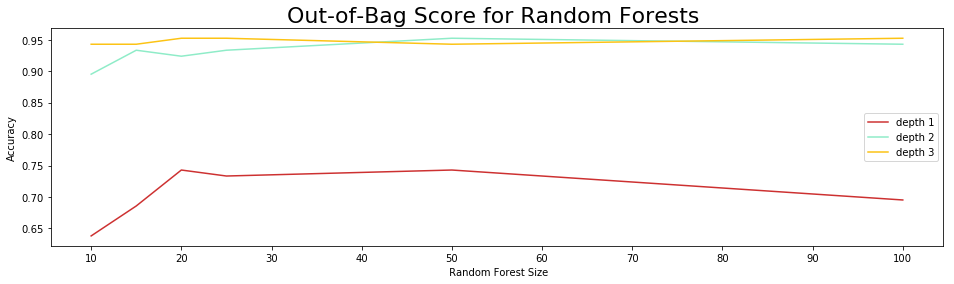

In [10]:
plt.close('all')
fig, ax = plt.subplots(figsize = (16,4))
ax.set_xlabel(' Random Forest Size')
ax.set_ylabel('Accuracy')
ax.set_title("Out-of-Bag Score for Random Forests ", fontsize =22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(forest_size,scores[0,:], label='depth 1', color='#CD3131')
ax.plot(forest_size,scores[1,:], label='depth 2', color='#8FECC8')
ax.plot(forest_size,scores[2,:], label='depth 3', color='#FCC314')
ax.legend(loc='center right', fontsize='medium')
plt.show()

<div class="alert alert-block alert-success">
Typically, the larger the number of trees, the better the performance of the random forest classifier at the expense of increased computational cost.
</div>

<div class="alert alert-block alert-success">
Increasing the size n of the bootstraping sample decreases randomness and thus the forest is more likely to overfit. Decreasing the size n reduces the degree of overfitting at the cost of model performance. 
</div>